### **Hands on quantization**

part1

Date: Jan 27, 2024

Written by: Dongyoung Lee

### **Yolo V2 Backbone: Darknet-19**

## **FUNDAMENTALS OF QUANTIZATION**


## **Mapping Function**




매핑 함수(Mapping function)는 부동소수점에서 정수 공간으로 값을 매핑한다. 


일반적으로 사용되는 매핑 함수는 다음과 같은 선형변환(Linear Transformation)이다.


###**Q(r) = round(r/S+Z)**



여기에서 **r은 입력값(FP), S는 Scaling Factor, Z는 offset**이다.

양자화된 값을 부동소수점으로 다시 복귀하기 위한 역함수(Inverse Function)는 다음과 같다.

### **r'=(Q(r)-Z)S**

r'!=r이고, 이들의 차이값을 양자화 에러(error) 또는 손실(loss)이라고 부른다. 

매핑 함수에 따라서 양자화 손실이 다를 수 있고, 이러한 손실을 최소화하는 것이 관건이다. 

딥러닝에서 양자화는 보통 정수 8비트(bitwidth)로 하는 것이 가장 보편적인데, 실제로는 정수 8비트가 아닌 고정소수점 8비트로 전환(매핑)하는 것이다. 

즉, 256개 이내의 서로 다른 소수점을 갖는 숫자로 전환(매핑)하는 것이다. 즉, 256개 이내의 서로 다른 소수점을 갖는 숫자로 전환하는 것이다.


### **Quantization Parameters**

매핑 함수는 스케일 인자(Scaling Factor) S와 제로 포인트(zero-point) Z의 파라미터들을 갖는다.(zero-point==offset)

.

### **Import Packages**

In [1]:
import os
import pickle
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision import datasets

In [ ]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available. Training on CPU ...")
else:
  print("CUDA is available! Training on GPU...")

CUDA is available! Training on GPU...


.

# **Accuracy Functions**

In [ ]:
#output: model output
#target: correct answer
#topk: number of k best model output

def accuracy(output, target ,topk=(1,)):
  """
  Computes the accuracy over the k top predictions for the specified values of k
  IN top-5 accuracy you give yourself credit for having the right answer
  if the right answer appears in your top five guesses
  """
  with torch.no_grad(): #no need for gradient
    maxk = max(topk) #store biggest topk value
    batch_size=target.size(0) #check batch size // express "target" tensor's 0th dimension size

    _, pred = output.topk(maxk,1,True,True) #maxk=bring upper k value / dim=selected class dimension / 1st True=largest, if smallest use False / 2nd True=sort result? yes=True, no=False
    pred = pred.t() #transpose tensor pred

    #correct = pred.eq(target. view(1, -1).expand_as(pred))
    #correct = (pred == target.view(1, -1).expand_as(pred))
    correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

    res = []
    for k in topk:
      #correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
      correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
      res.append(correct_k.mul(1.0/batch_size))
    return res

class AverageMeter(object):
  """Computes and stores the average and current value"""

  def __init__(self, name, fmt=':f'): #floating point format
    self.name = name
    self.fmt = fmt
    self.reset()

  def reset(self):
    self.val=0
    self.avg=0
    self.sum=0
    self.count=0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.num / self.count

  def __str__(self):
    #fmtstr = '{name} {val' + self.fmt + '}({avg' + self.fmt+ '})'
    fmtstr = '{name} ({avg' + self.fmt +  '})'

    return fmtstr.format(**self.__dict__)

def norm1(X,Y):
  return np.sum(np.abs(X-Y))

def norm2(X,Y):
  return np.sqrt(np.sum(np.square(X-Y)))


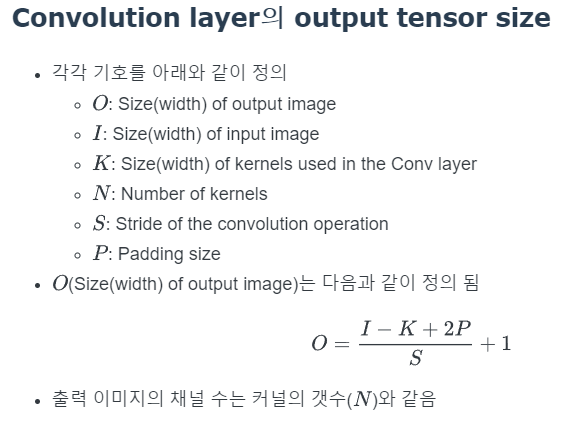

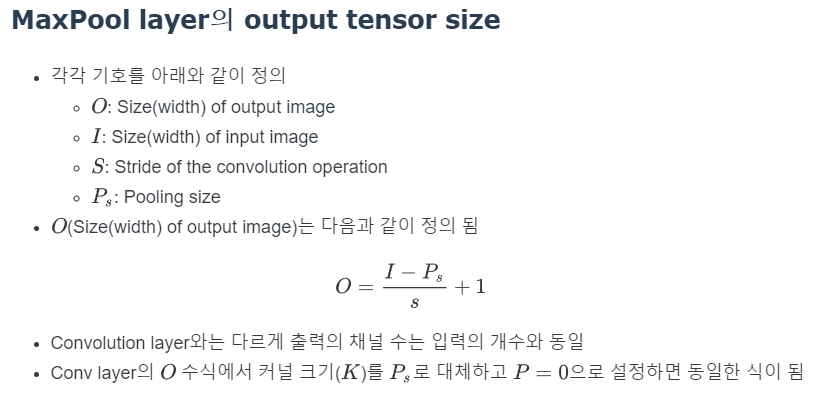

# **Define Network Architecture**

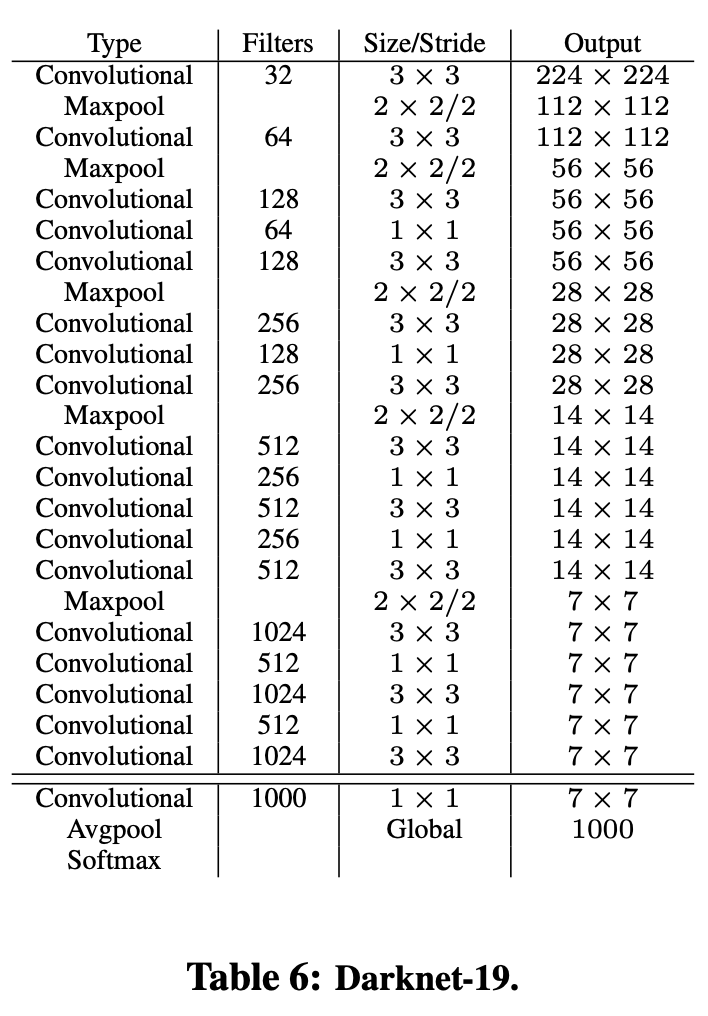

In [ ]:
class Darknet19(nn.Module): # formal inheritance method in PyTorch / inherit Parent class nn.Module
  def __init__(self, num_classes: int = 1000): # 1000 is number of classes for neuralnet model to predict. It is default. you can reset it when calling the function
    super(Darknet19, self).__init__() # super(child class name, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False) #3*3 require zero padding / 1*1 does not require zero padding
    self.batchnorm1 = nn.BatchNorm2d(32) #32개 channel 출력값을 normalization, Z function(평균, 분산)-->(0,1) gradient vanishing, exploding을 방지
    self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.1) #Relu negative slope

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False)
    self.batchnorm4 = nn.BatchNorm2d(64)
    self.leaky_relu4 = nn.LeakyReLU(negative_slope=0.1)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm5 = nn.BatchNorm2d(128)
    self.leaky_relu5 = nn.LeakyReLU(negative_slope=0.1)

    self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm6 = nn.BatchNorm2d(256)
    self.leaky_relu6 = nn.LeakyReLU(negative_slope=0.1)
    self.conv7 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False)
    self.batchnorm7 = nn.BatchNorm2d(128)
    self.leaky_relu7 = nn.LeakyReLU(negative_slope=0.1)
    self.conv8 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm8 = nn.BatchNorm2d(256)
    self.leaky_relu8 = nn.LeakyReLU(negative_slope=0.1)

    self.conv9 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm9 = nn.BatchNorm2d(512)
    self.leaky_relu9 = nn.LeakyReLU(negative_slope=0.1)
    self.conv10 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False)
    self.batchnorm10 = nn.BatchNorm2d(256)
    self.leaky_relu10 = nn.LeakyReLU(negative_slope=0.1)
    self.conv11 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm11 = nn.BatchNorm2d(512)
    self.leaky_relu11 = nn.LeakyReLU(negative_slope=0.1)
    self.conv12 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False)
    self.batchnorm12 = nn.BatchNorm2d(256)
    self.leaky_relu12 = nn.LeakyReLU(negative_slope=0.1)
    self.conv13 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm13 = nn.BatchNorm2d(512)
    self.leaky_relu13 = nn.LeakyReLU(negative_slope=0.1)

    self.conv14 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm14 = nn.BatchNorm2d(1024)
    self.leaky_relu14 = nn.LeakyReLU(negative_slope=0.1)
    self.conv15 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0, bias=False)
    self.batchnorm15 = nn.BatchNorm2d(512)
    self.leaky_relu15 = nn.LeakyReLU(negative_slope=0.1)
    self.conv16 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm16 = nn.BatchNorm2d(1024)
    self.leaky_relu16 = nn.LeakyReLU(negative_slope=0.1)
    self.conv17 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0, bias=False)
    self.batchnorm17 = nn.BatchNorm2d(512)
    self.leaky_relu17 = nn.LeakyReLU(negative_slope=0.1)
    self.conv18 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm18 = nn.BatchNorm2d(1024)
    self.leaky_relu18 = nn.LeakyReLU(negative_slope=0.1)

    self.conv19 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1, stride=1, padding=1, bias=False)
    self.avgpool= nn.AdaptiveAvgPool2d((1,1))
    self.max_pool2d=nn.MaxPool2d(2, stride=2)

  def forward(self, x):
    out=self.batchnorm1(self.conv1(x))
    out=self.leaky_relu1(out)
    out=self.max_pool2d(out)

    out=self.batchnorm2(self.conv2(x))
    out=self.leaky_relu2(out)
    out=self.max_pool2d(out)

    out=self.batchnorm3(self.conv3(x))
    out=self.leaky_relu3(out)
    out=self.batchnorm4(self.conv4(x))
    out=self.leaky_relu4(out)
    out=self.batchnorm5(self.conv5(x))
    out=self.leaky_relu5(out)
    out=self.max_pool2d(out)

    out=self.batchnorm6(self.conv6(x))
    out=self.leaky_relu6(out)
    out=self.batchnorm7(self.conv7(x))
    out=self.leaky_relu7(out)
    out=self.batchnorm8(self.conv8(x))
    out=self.leaky_relu8(out)
    out=self.max_pool2d(out)

    out=self.batchnorm9(self.conv9(x))
    out=self.leaky_relu9(out)
    out=self.batchnorm10(self.conv10(x))
    out=self.leaky_relu10(out)
    out=self.batchnorm11(self.conv11(x))
    out=self.leaky_relu11(out)
    out=self.batchnorm12(self.conv12(x))
    out=self.leaky_relu12(out)
    out=self.batchnorm13(self.conv13(x))
    out=self.leaky_relu13(out)
    out=self.max_pool2d(out)

    out=self.batchnorm14(self.conv14(x))
    out=self.leaky_relu14(out)
    out=self.batchnorm15(self.conv15(x))
    out=self.leaky_relu15(out)
    out=self.batchnorm16(self.conv16(x))
    out=self.leaky_relu16(out)
    out=self.batchnorm17(self.conv17(x))
    out=self.leaky_relu17(out)
    out=self.batchnorm18(self.conv18(x))
    out=self.leaky_relu18(out)

    out=self.conv19(out)
    out=self.avgpool(out)
    out=torch.flatten(out,1)

    return out

### **Build Model**

In [ ]:
model = Darknet19()
#print(model)

#weight_path = "C:\Bigdata\"quantization\darknet19_224d.pth"
#model.Load_state_dict(torch.Load(weigtht_path, map_Location=torch.device('cpu')))

weight_path = './darknet19_224d.pth'
model.load_state_dict(torch.load(weight_path))

### **Load Dataset**

In [ ]:
data_path = "\wrk\xsjhdnobkup5\taeheej\dataset\imagenet"
traindir = os.path.join(data_path, 'train')
valdir = os.path.join(data_path, 'val3k')

normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1,1,1]) #scale[0,1]--->normalization unpreceded

batch_size=32
num_workers=16

train_transform = transforms.Compose([
      transforms.RandomResizedCrop(224), #무작위로 이미지를 크롭(잘라내고)하고 224*224 pixel로 크기 조정
      transforms.RandomHorizontalFlip(), #이미지를 수평 방향으로 무작위로 뒤집기-데이터 다양성을 증가. 이미지 방향에 덜 민감
      transforms.ToTensor(), #이미지를 pytorch 텐서(pytorch 모델에서 처리할 수 있는 데이터 형식)로 변환. 이미지 데이터는 0에서 255 범위의 정수에서 0.0에서 1.0 범위의 부동소수점으로 스케일링
      normalize,
    ])

valid_transform=transforms.Compose([
      transforms.Resize(256), #모든 이미지의 크기를 256x256 픽셀로 조절한다.
      transforms.CenterCrop(224), #중앙을 기준으로 224x224로 크롭하여 크기 조정
      transforms.ToTensor(), #이미지를 pytorch 텐서로 변환
      normalize
    ])

train_dataset=datasets.ImageFolder(traindir, train_transform) #traindir 이미지를 가져와서 train_transform 전처리를 거치고 이미지 데이터셋을 생성한다.

valid_dataset=datasets.ImageFolder(valdir, valid_transform)

train_loader=torch.utils.data.DataLoader( #데이터 로드 및 처리
        train_dataset, #사용될 데이터셋
        batch_size=batch_size, #모델에 한번에 공급될 샘플수
        shuffle=True, #각 에프크(epoch) 시작시 데이터셋을 무작위로 섞어서 데이터의 순서에 의존하지 않도록 한다. overfitting을 방지한다.
        num_workers=num_workers,
        pin_memory=True) #Dataloader가 GPU에 복사하기 전에 CPU의 고정된 메모리 영역(pin된 메모리)에 로드하도록 한다. 이는 CPU에서 GPU로의 데이터 전송 속도를 향상시켜 학습 성능을 높인다.

valid_loader=torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True)

print("number of training dataset:%d" % len(train_dataset))
print("number of validation dataset:%d" % len(valid_dataset))

### **Qunatization of One Layer in Deep Learning Model**



**extract a weight from pretrained neural network**

In [ ]:
for name, param in model.named_parameters(): #model.named_parameters에서 이름과 값을 받아가는 코드 (name, param 말고 my_name, my_param으로 설정해도 됨 )
    layername = ".".join(name.split(".")[:1])
# print(Layername)
    if layername == "conv2":
        conv2 = param.cpu().detach().numpy() #해당 변수를 CPU('cpu()')로 이동시키고 계산 그래프에서 분리('detach()')하여 numpy 배열로 변환

In [ ]:
print(conv2.shape) #channel_out, channel_in, kernel_height, kernel_width

In [ ]:
plt.hist(conv2.flatten(), bins=1000)
plt.xlabel("variable")
plt.ylabel("count")
plt.xlim([-0.1, 0.1])
plt.title("floating point")
plt.grid()

### **Per-Tensor Quantization using Asymmetric Method**

**단일한 스케일과 오프셋을 사용하여 양자화 진행**


비대칭(Asymmetric) 양자화 방식은 입력 텐서의 범위로 최소, 최대 관찰값을 지정하는 것이다. 비대칭 양자화는 일반적으로 더 좁은 클리핑 범위를 제공하고, 음이 아닌 활성화(non-negative activation)을 양자화하는 데에 유용하다. 즉, 입력 텐서에 음이 포함되어 있지 않은 경우에 입력 텐서에 범위가 음이 될 필요가 없다.

**1.개별 스케일링과 오프셋 적용**: 굵은 텍스트 비대칭 양자화는 각 데이터 세트에 대해 독립적인 스케일링 인자(scale factor)와 오프셋(zero point)을 적용합니다. 이를 통해 데이터의 실제 범위에 더 잘 맞추어 양자화할 수 있습니다.

**2.데이터 특성 반영**: 가중치나 활성화 값의 실제 분포를 반영하여, 중요한 데이터 특성이 손실되지 않도록 보장합니다. 예를 들어, 데이터가 주로 양수 범위에 집중되어 있을 경우, 비대칭 양자화는 이를 효과적으로 포착하고 표현할 수 있습니다.

**3.정밀도 향상:** 비대칭 양자화는 데이터의 중요한 부분을 더 정밀하게 표현할 수 있도록 도와주어, 전체적인 모델의 정밀도와 성능을 유지하는 데 도움이 됩니다.


**최대/최소 값 설정:** Threshold는 양자화할 데이터의 범위를 결정합니다. 이는 데이터셋에서 가장 큰 값(maximum)과 가장 작은 값(minimum)을 설정하는 데 사용됩니다.

**데이터 손실 최소화:** 적절한 threshold 값을 설정함으로써 데이터의 중요한 특성을 유지하면서, 불필요하게 큰 값이나 작은 값으로 인한 데이터 손실을 최소화할 수 있습니다.

**양자화 정밀도 향상:** 데이터의 실제 범위 내에서 threshold를 적절히 설정함으로써, 양자화된 값들이 원본 데이터를 더 정밀하게 표현할 수 있게 됩니다

In [ ]:
# 1. Find Threshold
NBIT = 8              #양자화 비트
QRANGE = 2**(NBIT)    #양자화 갯수, Asymmetric quantization에서는 전부 양의 값으로 cliping(0~255)되기 때문에 data가 전부 양의 값으로 양자화된다.
                      #따라서, 8bit 모두 value값으로 사용 가능하기 때문에 NBIT 크기 그대로 사용한다. 

threshold = np.max(conv2) - np.min(conv2)     #입력값의 클리핑 범위

# 2. find quantized step
step = threshold/QRANGE      #양자화 resolution
scale = QRANGE/threshold     #양자화 scale factor
print("QRANGE:", QRANGE)
print("threshold:", threshold)
print("step", step)
print("scale", scale)

# 3. quantize using 8 bit
#data_q=np.round(conv2*scale)
data_q = np.round(conv2/step) # 양자화(quantization)

# 4. dequantize using scale factor (to be fixed point number)
data_qn=data_q/scale

#count unique values
print(len(np.unique(data_qn))) #배열에서 중복되는 숫자 제거 ex) [1,2,2,3,3,4] --> [1,2,3,4]

In [ ]:

plt.hist(data_qn.flatten(), bins=len(np.unique(data_qn)))  #Matplotlib을 사용해서 data_qn 배열의 값 분포를 히스토그램(막대그래프)으로 나타내는것
                                                           #data_qn을 1차원 배열로 변환 / bin(막대)가 1,2,3,4 한개씩 해당하는 4개의 bin이 설정된다는 뜻
plt.xlabel("variable")
plt.ylabel("count")
plt.xlim([-0.1, 0.1])
plt.title("fixed point in asymmetric quantization")
plt.grid()

In [ ]:
#Quantization Loss
print('loss at norm1:', norm1(conv2, data_qn))
print('loss at norm2:', norm2(conv2, data_qn))

### **Per-Tensor Quantization using Symmetric method**

대칭(Symmetric) 양자화 방식은 입력 텐서의 범위가 0을 중심으로 대칭적으로 분포한다고 가정하고있으며, 따라서 영점 오프셋(zero offset)을 고려할 필요가 없다.

In [ ]:
#1. Find Threshold
NBIT = 8 #quantization bit
QRANGE = 2**(NBIT-1) #quantization range, Symmetric quantization을 하게되면 data가 min, max가 절댓값이 같은 음, 양의 값을 가지게 되어 sign bit로 1bit를
                     #사용해야한다. 따라서, 1bit를 뺀 나머지 비트를 사용하게 되어 QRANGE 값이 asymmetric 경우와 다르게 된다. 

threshold = np.max([np.abs(np.max(conv2)), np.abs(np.min(conv2))])

#2. Find quantized step
step = threshold/QRANGE
scale = QRANGE/threshold # sclaing factor은 보통 1보다 작다

#3. quantize using 8 bit
data_q = np.round(conv2/step)

#4. dequantize using scale factor
data_qn = data_q/scale

#count unique values
print(len(np.unique(data_qn)))

In [ ]:
plt.hist(data_qn.flatten(), bins=len(np.unique(data_qn)))
plt.xlabel("variable")
plt.ylabel("count")
plt.title("fixed point in symmetric quantization")
plt.grid()

In [ ]:
#Quantization Loss
print('loss at norm1:', norm1(conv2, data_qn))
print('loss at norm2:', norm2(conv2, data_qn))

비대칭 양자화에 비해서 zero를 중심으로 좀더 대칭적으로 분포되어 있는 것을 확인할 수 있다. 

비대칭 양자화에 비해서 unique values의 수가 181개에서 172개로 감소하였다. 

즉, threshold가 약간 증가하면서 양자화 손실이 약간 증가하였다.

### **Per-Channel Quantization**



텐서별로(per-tensor) 양자화하는 경우에 동일한 클리핑 범위를 한 텐서의 모든 채널에 동일하게 적용된다.

반면에 채널별로(per-channel) 양자화는 채널별로 각기 다른 클리핑 범위를 적용한다.

채널당 양자화는 텐서당 양자화에 비해서 좀더 나은 정확도를 제공할 가능성이 크다.

그렇지만, 양자화 파라미터의 수가 채널수에 비례해서 증가하는 단점이 있다.

대칭 양자화에 대해서 채널당 양자화의 workflow는 다음과 같다.

In [ ]:
#1. find threshold
NBIT = 8
QRANGE = 2**(NBIT-1) # Symmetric Quantization

data_q = conv2.copy() #메모리의 새로운 위치에 conv2 복사해서 넣음
data_qn = conv2.copy()

for i in range(len(conv2)):
    threshold = np.max([np.abs(np.max(conv2[i,...])), np.abs(np.min(conv2[i,...]))])
    #conv2 배열의 i번째 요소에 접근하되, 나머지 모든 차원은 그대로 유지

    #2. find quantized step
    step = threshold / QRANGE
    scale = QRANGE / threshold
    
    #3. quantize using 8 bit
    data_q[i,...] = np.round(conv2[i,...]/step) 

    #4. dequantize using scale factor
    data_qn[i,...] = data_q[i,...]/scale

In [ ]:
#count unique values
print(len(np.unique(data_qn)))

In [ ]:
plt.hist(data_qn.flatten(), bins=1000)
plt.xlabel('variable')
plt.ylabel('count')
plt.xlim([-0.1, 0.1])
plt.title('fixed point in per-channel, symmetric quantization')
plt.grid()

In [ ]:
#quantization loss
print('loss at norm1:', norm1(conv2, data_qn))
print('loss at norm2:', norm2(conv2, data_qn))